In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms

### 이미지 리사이즈 (원본 비율 유지)

- 이미지 리사이즈 공통 함수

In [ ]:
def resize_image(img) :
    # 원본 이미지 크기
    origin_size = img.shape[:2]

    # 조정할 이미지 사이즈
    resize = 224

    # 이미지의 높이(h)와 너비(w) 중 가장 긴 변을 기준으로 비율 조정
    # 예를 들어, 원본 이미지 크기가 2268(w)x4032(h) 라면 가장 긴 변인 4032 를 기준으로 224로 맞추기 위한 비율 계산
    # 계산된 비율로 이미지의 모든 변을 조정
    ratio = float(resize) / max(origin_size)
    new_size = tuple([int(x * ratio) for x in origin_size])

    # 리사이즈
    resized_image = cv2.resize(img, (new_size[1], new_size[0]))

    # 패딩 추가
    # 리사이즈 된 이미지가 224x224 크기에 맞지 않을 수 있으므로 패딩 계산 필요
    # 예를 들어, 새로운 이미지 크기가 126(w)x224(h) 라면 너비가 부족하므로 좌우에 49픽셀씩 패딩 추가
    delta_w = resize - new_size[1]
    delta_h = resize - new_size[0]

    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [0, 0, 0]
    new_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return new_image

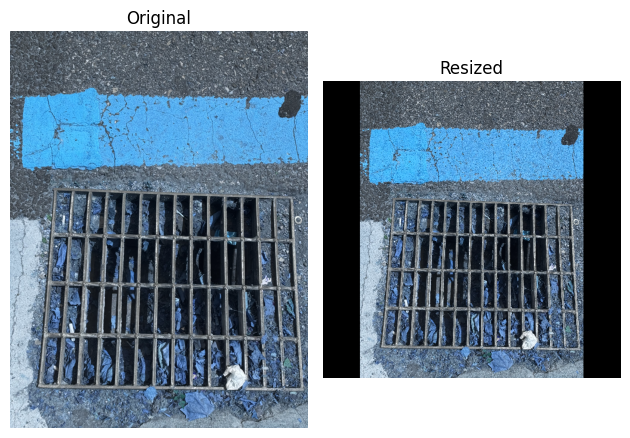

In [24]:
# 이미지 리사이즈
image = cv2.imread('heavy_62/heavy_1.jpeg')
new_image = resize_image(image)

# 원본
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original')
plt.axis('off')

# 출력
plt.subplot(1, 2, 2)
plt.imshow(new_image)
plt.title('Resized')
plt.axis('off')

plt.tight_layout()
plt.show()

### 캐니 엣지 검출

In [29]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
canny1 = cv2.Canny(gray, 50, 150)
canny2 = cv2.Canny(gray, 100, 200)

height = 500
scale = height / image.shape[0]

resized_gray = cv2.resize(gray, None, fx=scale, fy=scale)
resized_canny1 = cv2.resize(canny1, None, fx=scale, fy=scale)
resized_canny2 = cv2.resize(canny2, None, fx=scale, fy=scale)
combined = np.hstack((resized_gray, resized_canny1, resized_canny2))

cv2.imshow('Gray | Canny1 | Canny2', combined)
cv2.waitKey(0)
cv2.destroyAllWindows()

### 경계선 찾기

In [30]:
img_copy = image.copy()

canny = cv2.Canny(gray, 100, 200)
contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
lcontour = [i for i in contours if len(i) > 100]
cv2.drawContours(img_copy, lcontour, -1, (0, 255, 0), 3)

height = 500
scale = height / image.shape[0]

resized_origin = cv2.resize(image, None, fx=scale, fy=scale)
resized_result = cv2.resize(img_copy, None, fx=scale, fy=scale)
combined = np.hstack((resized_origin, resized_result))

cv2.imshow('Original | Result', combined)
cv2.waitKey(0)
cv2.destroyAllWindows()

### 허프 변환

In [ ]:
edge = cv2.Canny(new_image, 50, 150, apertureSize=3)

minLineLength = 50
maxLineGap = 10

lines = cv2.HoughLinesP(edge, 1, np.pi / 180, 100, minLineLength, maxLineGap)

if lines is None :
    print('no lines')
else :
    for line in lines :
        x1, y1, x2, y2 = line[0]
        cv2.line(new_image, (x1, y1), (x2, y2), (0, 0, 255), 2)

cv2.imshow('Hough', new_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

### 이미지 윤곽선 검출

In [3]:
# img = cv2.imread('clean/IMG_9380.JPG')
# img = cv2.imread('heavy/IMG_9514.JPG')
# img = cv2.imread('heavy_aug/IMG_9548_aug2.jpg')
img = cv2.imread('medium/IMG_9409.JPG')
new_img = resize_image(img)

# 이미지 채널 변경
gray = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
# cv2.imshow('gray', gray)

# 이미지 이진화 수행
# 최대 임계값 : 255
# 임계 처리 : 가우시안 필터 사용 (블러 처리도 함께 적용됨)
# 임계치 처리 적용 영역 크기 : 9
# 평균이나 가중 평균에서 차감할 값 : 5
dst = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 5)
# cv2.imshow('dst', ret)

# 이미지 블러 처리
# 노이즈를 줄이기 위함
gray = cv2.GaussianBlur(dst, (7, 7), 0)
# cv2.imshow('blured', gray)

# 이미지 경계선(픽셀의 값이 갑자기 커지거나 작아지는 부분) 검출
edged = cv2.Canny(gray, 100, 200)
# cv2.imshow('canny', edged)

# # 탐지한 경계선 두껍게 만들기
edged = cv2.dilate(edged, None, iterations=1)
# cv2.imshow('dilated', edged)

# 탐지한 경계선 얇게 만들기
edged = cv2.erode(edged, None, iterations=1)
# cv2.imshow('eroded', edged)

# 이미지 윤곽선 검출 (검출한 윤곽선 좌표, 계층 정보 리턴)
# cv2.RETR_EXTERNAL : 가장 바깥쪽 라인 검출
# cv2.CHAIN_APPROX_SIMPLE : 끝 점만 남기고 다른 점(수평, 수직, 대각선 방향)들은 모두 제거
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 가장 큰 윤곽선
largest_contour = max(contours, key=cv2.contourArea)
# 가장 큰 윤곽선 넓이 (단위 : 픽셀)
largest_area = cv2.contourArea(largest_contour)
print(largest_area)

# 결과 이미지
result_img = new_img.copy()
for i, contour in enumerate(contours) :
    mmt = cv2.moments(contour)
    # 윤곽선 중심점 계산
    cx = int(mmt['m10'] / mmt['m00'])
    cy = int(mmt['m01'] / mmt['m00'])
    # print(cx, cy)

    # 영역 넓이 (단위 : 픽셀)
    area = mmt['m00']
    # 영역 외곽선 길이
    length = cv2.arcLength(contour, True)

    # 윤곽선 표시 - 노란색
    cv2.drawContours(result_img, [contour], -1, (0, 255, 255), 2)
    
    # 윤곽선 중심점 표시 - 파란색
    cv2.circle(result_img, (cx, cy), 3, (255, 0, 0), -1)

    # 영역 넓이 표시
    cv2.putText(result_img, f'A : {area:.0f}', (cx, cy+20), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 2)

    # 영역 외곽선 길이 표시
    cv2.putText(result_img, f'L : {length:.2f}', tuple(contour[0][0]), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2)

    # 가장 큰 윤곽선 정보만 표시
    # if largest_area == area : 
    #     cv2.drawContours(result_img, [contour], -1, (0, 255, 255), 2)
        
    #     # 컨투어 중심점 표시
    #     cv2.circle(result_img, (cx, cy), 3, (255, 0, 0), -1)

    #     # 영역 넓이 표시
    #     cv2.putText(result_img, f'A : {area:.0f}', (cx, cy+20), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 2)

    #     # 영역 외곽선 길이 표시
    #     cv2.putText(result_img, f'L : {length:.2f}', tuple(contour[0][0]), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2)

    # 각 윤곽선별 넓이 계산
    print(f'area : {cv2.contourArea(contour, False):.2f}')

# 실제 면적 계산
# 픽셀 당 몇 cm 인지 안다는 가정이 필요
pixel_ratio = 50
largest_area_cm = largest_area / (pixel_ratio ** 2)
print(f'가장 큰 영역의 실제 면적 (추정) : {largest_area_cm:.2f} ㎠')

cv2.imshow('contours', result_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

34598.5
area : 1.50
area : 12.50
area : 16.00
area : 5.00
area : 7.00
area : 88.50
area : 34598.50
가장 큰 영역의 실제 면적 (추정) : 13.84 ㎠


### ROI(Region Of Interest) 영역 추출

In [ ]:
# 원본 이미지 폴더 & 저장 폴더 설정
img_dir = 'heavy_62'
save_dir = 'roi'

# ROI 이미지 저장 디렉토리 생성
if not os.path.exists(save_dir) :
    os.makedirs(save_dir)

is_dragged = False
ix, iy = -1, -1
blue, yellow = (255, 0, 0), (0, 255, 255)

# 마우스 클릭하고 뗄 때, 이미지 위에 직사각형 그리는 함수
def onMouse(event, x, y, flags, param) :
    global is_dragged, ix, iy, blue, yellow

    # 마우스를 눌렀을 때, 초기 위치 저장
    if event == cv2.EVENT_LBUTTONDOWN :
        is_dragged = True
        ix, iy = x, y
    # 마우스를 드래그 할 때, 파란색 직사각형 그리기
    elif event == cv2.EVENT_MOUSEMOVE and is_dragged :
        img_draw = param.copy()
        cv2.rectangle(img_draw, (ix, iy), (x, y), blue, 1)
        cv2.imshow('Show Image', img_draw)
    # 마우스를 뗐을 때, 이미지 위에 노란색색 직사각형 그리기
    # ix, iy : 마우스 처음 클릭한 위치
    # x, y : 마우스 뗐을때의 그 위치
    # w, h : 직사각형 너비, 높이
    elif event == cv2.EVENT_LBUTTONUP :
        if is_dragged :
            is_dragged = False
            w = x - ix
            h = y - iy

            # 드래그한 직시각형 영역이 있을 때, 관심영역 찾기
            if w > 0 and h > 0 :
                cv2.rectangle(param, (ix, iy), (x, y), yellow, 1)
                cv2.imshow('Show Image', param)

                # 이미지에서 관심영역만 분리하여 새 창에 노출
                roi = param[iy:iy+h, ix:ix+w]
                cv2.imshow('ROI', roi)
                cv2.moveWindow('ROI', 500, 250)

                # 관심영역 이미지로 저장
                roi_filename = f'{save_dir}/roi_{os.path.basename(img_path)}'
                cv2.imwrite(roi_filename, roi)
                print(f'Saved: {roi_filename}')

# 지정된 이미지 디렉토리 순회
for filename in os.listdir(img_dir) :
    if filename.endswith('.JPG') or filename.endswith('.jpg') or filename.endswith('.jpeg') :
        img_path = os.path.join(img_dir, filename) 
        img = cv2.imread(img_path)

        # 이미지 리사이즈
        new_img = resize_image(img)
        cv2.imshow('Show Image', new_img)
        cv2.setMouseCallback('Show Image', onMouse, param=new_img)
        key = cv2.waitKey(0)

        # Space : 다음 페이지로 이동
        if key == 32 :
            cv2.destroyAllWindows()
            continue
        # ESC : 종료 
        elif key == 27 :
            break

cv2.destroyAllWindows()

Saved: roi/roi_heavy_1.jpeg
Saved: roi/roi_heavy_10.JPG
Saved: roi/roi_heavy_11.JPG
Saved: roi/roi_heavy_12.JPG
Saved: roi/roi_heavy_13.JPG
Saved: roi/roi_heavy_14.JPG
Saved: roi/roi_heavy_15.JPG
Saved: roi/roi_heavy_16.JPG
Saved: roi/roi_heavy_17.JPG
Saved: roi/roi_heavy_18.JPG
Saved: roi/roi_heavy_19.JPG
Saved: roi/roi_heavy_2.jpeg
Saved: roi/roi_heavy_20.JPG
Saved: roi/roi_heavy_21.jpg
Saved: roi/roi_heavy_22.jpg
Saved: roi/roi_heavy_23.jpg
Saved: roi/roi_heavy_24.jpg
Saved: roi/roi_heavy_25.jpg
Saved: roi/roi_heavy_26.jpg
Saved: roi/roi_heavy_27.jpg
Saved: roi/roi_heavy_28.jpg
Saved: roi/roi_heavy_29.jpg
Saved: roi/roi_heavy_3.JPG
Saved: roi/roi_heavy_30.jpg
Saved: roi/roi_heavy_31.jpg
Saved: roi/roi_heavy_32.jpg
Saved: roi/roi_heavy_33.jpg
Saved: roi/roi_heavy_34.jpg
Saved: roi/roi_heavy_35.jpg
Saved: roi/roi_heavy_36.jpg
Saved: roi/roi_heavy_37.jpg
Saved: roi/roi_heavy_38.jpg
Saved: roi/roi_heavy_39.jpg
Saved: roi/roi_heavy_4.JPG
Saved: roi/roi_heavy_40.jpg
Saved: roi/roi_heavy_4

그림자 비율: 11.73%


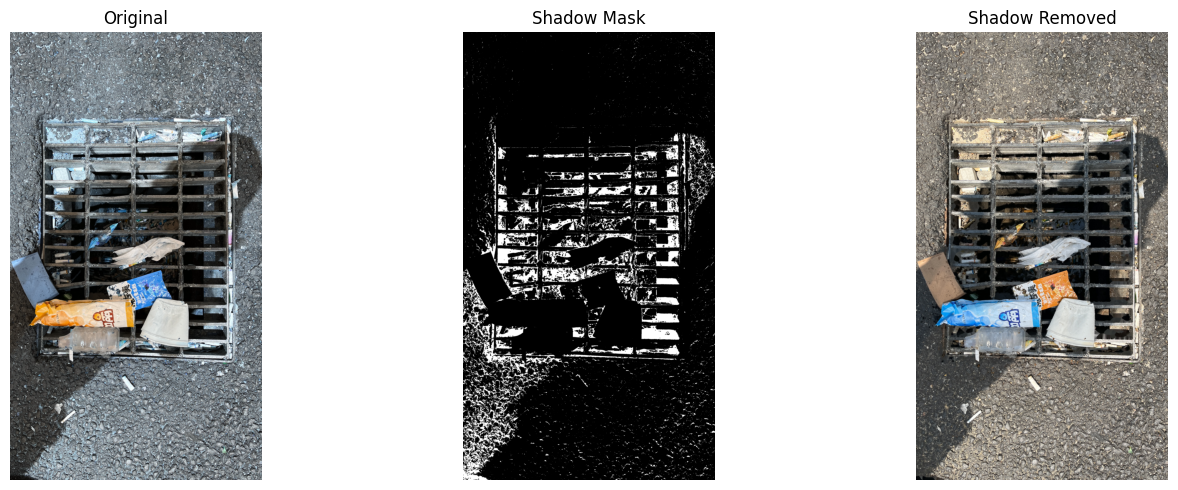

In [ ]:
image_path = 'heavy/IMG_9489.JPG'
img = cv2.imread(image_path)

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# RGB 채널 이미지
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# HSV 채널 이미지
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# HSV에서 밝기 추출
# hue : 색깔
# saturation : 채도 (색의 진하고 연한 정도)
# value : 명도 (색의 밝고 어두운 정도)
hue, saturation, value = cv2.split(img_hsv)

# 그림자 마스크 생성
value_mask = cv2.inRange(value, 0, 40)
saturation_mask = cv2.inRange(saturation, 0, 80)
shadow_mask = cv2.bitwise_and(value_mask, saturation_mask)

# 모폴로지
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
shadow_mask = cv2.morphologyEx(shadow_mask, cv2.MORPH_CLOSE, kernel)

# 전체 픽셀 수와 그림자 픽셀 수 계산
total_pixels = shadow_mask.size
shadow_pixels = cv2.countNonZero(shadow_mask)
# 그림자 비율 계산
shadow_ratio = (shadow_pixels / total_pixels) * 100
print(f'그림자 비율: {shadow_ratio:.2f}%')

# 그림자 역마스크 생성
shadow_mask_inv = cv2.bitwise_not(shadow_mask)

# 그림자 제거
shadow_removed = cv2.inpaint(img_rgb, shadow_mask, 3, cv2.INPAINT_TELEA)

# 결과 시각화
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Shadow Mask')
plt.imshow(shadow_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Shadow Removed')
plt.imshow(shadow_removed)
plt.axis('off')

plt.tight_layout()
plt.show()

### 이미지 크롭

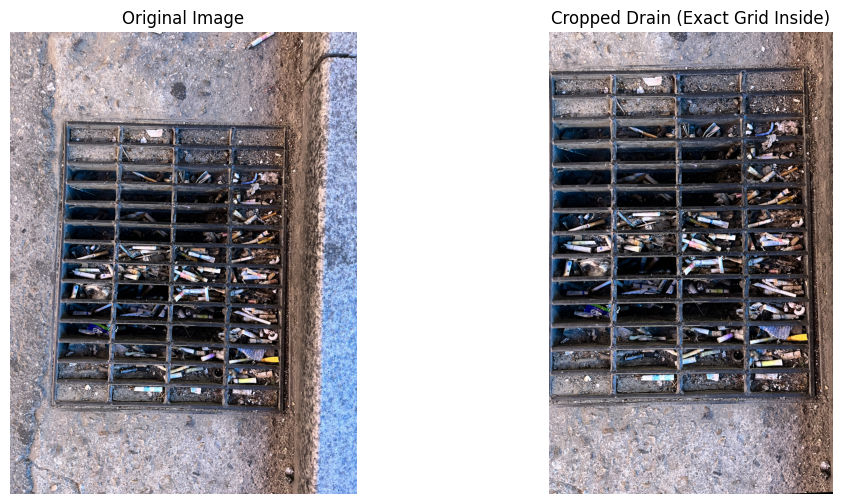

In [3]:
# 원본 이미지 폴더 & 저장 폴더 설정
img_dir = 'heavy_62'
crop_dir = 'heavy_62_grabcut'

# 크롭 이미지 저장 디렉토리 생성
if not os.path.exists(crop_dir) :
    os.makedirs(crop_dir, exist_ok=True)

def crop_drain_inside_outline(image_path):
    img_color = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

    # ---- Gabor filter로 격자 강조 ----
    def apply_gabor(img, theta):
        kernel = cv2.getGaborKernel((31, 31), 4.0, theta, 10.0, 0.5, 0)
        return cv2.filter2D(img, cv2.CV_8UC3, kernel)

    gabor_0 = apply_gabor(img_gray, 0)
    gabor_90 = apply_gabor(img_gray, np.pi / 2)
    gabor = cv2.addWeighted(gabor_0, 0.5, gabor_90, 0.5, 0)

    # ---- Canny edge + 윤곽선 ----
    edges = cv2.Canny(gabor, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # ---- 가장 큰 윤곽선 찾기 (격자 전체 테두리로 추정) ----
    max_area = 0
    best_cnt = None
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > max_area:
            max_area = area
            best_cnt = cnt

    if best_cnt is None:
        print("❌ 윤곽선을 찾지 못함")
        return None, None

    # ---- 외곽 윤곽선 -> 회전된 박스 좌표로 변환 ----
    rect = cv2.minAreaRect(best_cnt)
    box = cv2.boxPoints(rect)
    box = box.astype(np.intp)

    # 좌표 정렬 (좌상-우상-우하-좌하 순서)
    def order_points(pts):
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        diff = np.diff(pts, axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect

    ordered = order_points(box)

    # 투시 변환으로 내부만 정밀 크롭
    (tl, tr, br, bl) = ordered
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)

    maxWidth = int(max(widthA, widthB))
    maxHeight = int(max(heightA, heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(ordered, dst)
    warped = cv2.warpPerspective(img_color, M, (maxWidth, maxHeight))

    # 결과 반환 (PIL 이미지)
    original_pil = Image.fromarray(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
    cropped_pil = Image.fromarray(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    return original_pil, cropped_pil

# 이미지 저장
for file in os.listdir(img_dir) :
    if file.lower().endswith(('.jpg', '.jpeg', '.png')) :
        img_path = os.path.join(img_dir, file)

        # 이미지 크롭
        orig, cropped = crop_drain_inside_outline(img_path)
        cropped.save(os.path.join(crop_dir, f'cropped_{file}'))
        
# 시각화
if cropped:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(orig)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cropped)
    plt.title("Cropped Drain (Exact Grid Inside)")
    plt.axis("off")
    plt.show()
else:
    print("⚠️ 크롭 실패")

### 학습/테스트 데이터 분리

In [6]:
import shutil

# 이미지 위치
origin_dir = 'service_not'
train_dir = 'service_not_train(7)'
test_dir = 'service_not_test(3)'

# 데이터 분할 비율
train_size = 0.7

# 모든 이미지 파일
image_files = [file for file in os.listdir(origin_dir) if file.lower().endswith(('.jpg', '.jpeg', '.png'))]

# 랜덤하게 섞기
np.random.shuffle(image_files)

# 데이터 분할 지점
split_idx = int(len(image_files) * train_size)

# 데이터 분할
train_files = image_files[:split_idx]
test_files = image_files[split_idx:]

# 학습/테스트 데이터 저장 디렉토리 생성
# 학습 데이터 디렉토리
if not os.path.exists(train_dir) :
    os.makedirs(train_dir, exist_ok=True)

# 테스트 데이터 디렉토리
if not os.path.exists(test_dir) :
    os.makedirs(test_dir, exist_ok=True)

# 파일 복사
# 학습 데이터
for file in train_files : 
    shutil.copy(os.path.join(origin_dir, file), os.path.join(train_dir, file))

# 테스트 데이터
for file in test_files :
    shutil.copy(os.path.join(origin_dir, file), os.path.join(test_dir, file))

print(f'총 {len(image_files)}개 파일 - 학습 데이터 : {len(train_files)}개, 테스트 데이터 : {len(test_files)}개')

총 292개 파일 - 학습 데이터 : 204개, 테스트 데이터 : 88개


### 이미지 증강

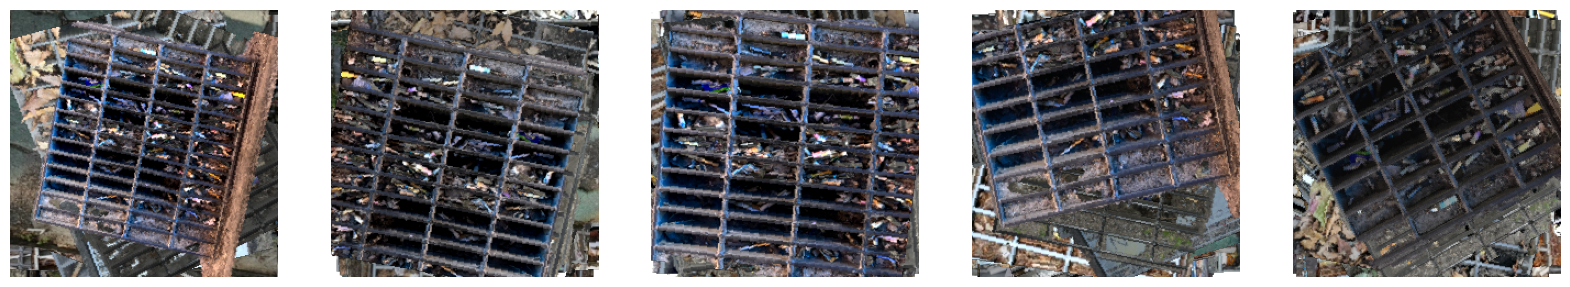

In [ ]:
transform = transforms.Compose([
    # 랜덤 크롭 - 패딩 지정
    transforms.RandomResizedCrop(244, scale=(0.3, 0.8), ratio=(3/4, 4/3)),
    # 랜덤 좌우 반전
    transforms.RandomHorizontalFlip(),
    # 랜덤 상하 반전
    transforms.RandomVerticalFlip(),
    # 랜덤 회전
    transforms.RandomRotation(30),
    # 이미지 속성 랜덤하게 변경 - 밝기/대비/채도
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3)
])

# 이미지 위치
origin_dir = 'heavy_62_grabcut_sample'
aug_dir = 'heavy_62_grabcut_aug'

# 증강 이미지 저장 디렉토리 생성
if not os.path.exists(aug_dir) :
    os.makedirs(aug_dir, exist_ok=True)

fig = plt.figure(figsize=(20, 20))

# 이미지 증강
for file in os.listdir(origin_dir) :
    if file.lower().endswith(('.jpg', '.jpeg', '.png')) :
        img = Image.open(os.path.join(origin_dir, file))
        
        # 한 이미지당 5개씩 증강
        for i in range(5) :
            aug_img = transform(img)
            aug_img.save(os.path.join(aug_dir, f'aug{i}_{file}'))

            # 화면 노출
            sub = fig.add_subplot(1, 5, i + 1)
            plt.imshow(aug_img)
            plt.axis('off')

### 이미지 배경 제거

In [7]:
import cv2
import numpy as np
import os

img_dir = 'medium'
grabcut_dir = 'medium_clean_325_grabcut'

if not os.path.exists(grabcut_dir) :
    os.makedirs(grabcut_dir, exist_ok=True)

# 배경 제거
def grabcut(img) :
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # ---- Gabor filter로 격자 강조 ----
    def apply_gabor(img, theta):
        kernel = cv2.getGaborKernel((31, 31), 4.0, theta, 10.0, 0.5, 0)
        return cv2.filter2D(img, cv2.CV_8UC3, kernel)

    gabor_0 = apply_gabor(gray, 0)
    gabor_90 = apply_gabor(gray, np.pi / 2)
    gabor = cv2.addWeighted(gabor_0, 0.5, gabor_90, 0.5, 0)

    # ---- 엣지 검출 및 윤곽선 추출 ----
    edges = cv2.Canny(gabor, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # ---- 가장 큰 윤곽선 찾기 ----
    if not contours :
        return None

    max_cnt = max(contours, key=cv2.contourArea)
    if cv2.contourArea(max_cnt) < 100:  # 너무 작은 contour는 무시
        return None

    # 외곽 윤곽선 추출하여 전경 이미지를 감싸는 사각형 박스 설정
    box = cv2.boxPoints(cv2.minAreaRect(max_cnt)).astype(np.intp)
    x, y, w_box, h_box = cv2.boundingRect(box)
    rect = (x, y, w_box, h_box)

   # 초기 마스크 설정
    mask = np.zeros(img.shape[:2], np.uint8)

    # grabcut 알고리즘에 사용하는 배열 생성
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    # GrabCut 적용
    try :
        cv2.grabCut(img, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)
    except Exception as e :
        print(f'GrabCut 실패: {e};')
        return None

    # 전경(1)과 배경(0) 분리
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    if np.count_nonzero(mask2) == 0 :
        return None

    # RGBA 이미지로 변환
    b, g, r = cv2.split(img)
    alpha = (mask2 * 255).astype(np.uint8)
    rgba = cv2.merge((b, g, r, alpha))

    return rgba

for file in os.listdir(img_dir):
    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(img_dir, file)
        img = cv2.imread(img_path)

        if img is None :
            print(f'이미지 로드 실패 : {file}')
            continue

        print(f'GrabCut 처리 중: {file}')
        grabcut_img = grabcut(img)

        if grabcut_img is None :
            print(f'GrabCut 실패 또는 결과 없음 : {file}')
            continue

        # 배경 제거 이미지 저장
        save_path = os.path.join(grabcut_dir, f'grabcut_{os.path.splitext(file)[0]}.png')
        cv2.imwrite(save_path, grabcut_img)
        print(f'✅ 저장 완료: {save_path}')

GrabCut 처리 중: medium_clean_50.jpg
✅ 저장 완료: medium_clean_325_grabcut\grabcut_medium_clean_50.png
GrabCut 처리 중: medium_clean_51.jpeg
✅ 저장 완료: medium_clean_325_grabcut\grabcut_medium_clean_51.png
GrabCut 처리 중: medium_clean_52.jpeg
✅ 저장 완료: medium_clean_325_grabcut\grabcut_medium_clean_52.png
GrabCut 처리 중: medium_clean_53.jpg
✅ 저장 완료: medium_clean_325_grabcut\grabcut_medium_clean_53.png
GrabCut 처리 중: medium_clean_54.jpeg
✅ 저장 완료: medium_clean_325_grabcut\grabcut_medium_clean_54.png
GrabCut 처리 중: medium_clean_55.jpeg
✅ 저장 완료: medium_clean_325_grabcut\grabcut_medium_clean_55.png
GrabCut 처리 중: medium_clean_56.jpeg
✅ 저장 완료: medium_clean_325_grabcut\grabcut_medium_clean_56.png
GrabCut 처리 중: medium_clean_57.jpg
✅ 저장 완료: medium_clean_325_grabcut\grabcut_medium_clean_57.png
GrabCut 처리 중: medium_clean_58.jpg
✅ 저장 완료: medium_clean_325_grabcut\grabcut_medium_clean_58.png
GrabCut 처리 중: medium_clean_59.jpeg
✅ 저장 완료: medium_clean_325_grabcut\grabcut_medium_clean_59.png
GrabCut 처리 중: medium_clean_60.jpg


In [33]:
import cv2
import numpy as np

class GrabCutApp:
    def __init__(self, img_path):

        self.image = cv2.imread(img_path)
        self.image = resize_image(self.image)
        if self.image is None:
            raise ValueError("이미지를 불러올 수 없습니다.")
        self.mask = np.zeros(self.image.shape[:2], dtype=np.uint8)
        self.bgdModel = np.zeros((1, 65), np.float64)
        self.fgdModel = np.zeros((1, 65), np.float64)
        self.res = self.image.copy()
        self.initRect = (0, 0, 0, 0)
        self.initState = True
        self.prevPt = None
        self.window_name = "src"
        cv2.namedWindow(self.window_name)
        cv2.setMouseCallback(self.window_name, self.mouse_event)
        self.run()

    def mouse_event(self, event, x, y, flags, param):
        if self.initState:
            if event == cv2.EVENT_LBUTTONDOWN:
                self.initRect = [x, y, 0, 0]
            elif event == cv2.EVENT_MOUSEMOVE and (flags & cv2.EVENT_FLAG_LBUTTON):
                temp = self.image.copy()
                rect = (self.initRect[0], self.initRect[1], x - self.initRect[0], y - self.initRect[1])
                cv2.rectangle(temp, rect, (0, 0, 255), 2)
                cv2.imshow(self.window_name, temp)
            elif event == cv2.EVENT_LBUTTONUP:
                self.initRect[2] = x - self.initRect[0]
                self.initRect[3] = y - self.initRect[1]
                self.initRect = (
                    max(0, self.initRect[0]),
                    max(0, self.initRect[1]),
                    min(self.initRect[2], self.image.shape[1] - self.initRect[0]),
                    min(self.initRect[3], self.image.shape[0] - self.initRect[1])
                )
                self.mask[:] = cv2.GC_BGD
                x, y, w, h = self.initRect
                self.mask[y:y+h, x:x+w] = cv2.GC_PR_FGD
                cv2.grabCut(self.image, self.mask, self.initRect, self.bgdModel, self.fgdModel, 1, cv2.GC_INIT_WITH_RECT)
                self.show_result()
                self.initState = False
        else:
            if event == cv2.EVENT_LBUTTONDOWN:
                self.prevPt = (x, y)
            elif event == cv2.EVENT_MOUSEMOVE and (flags & cv2.EVENT_FLAG_LBUTTON):
                if flags & cv2.EVENT_FLAG_CTRLKEY:
                    cv2.line(self.res, self.prevPt, (x, y), (0, 255, 255), 4)
                    cv2.line(self.mask, self.prevPt, (x, y), cv2.GC_BGD, 4)
                elif flags & cv2.EVENT_FLAG_SHIFTKEY:
                    cv2.line(self.res, self.prevPt, (x, y), (255, 255, 0), 4)
                    cv2.line(self.mask, self.prevPt, (x, y), cv2.GC_FGD, 4)
                self.prevPt = (x, y)
                cv2.imshow(self.window_name, self.res)

    def show_result(self):
        binMask = (self.mask & 1).astype(np.uint8)
        black = np.zeros_like(self.image)
        black[binMask == 1] = (255, 255, 255)
        self.res = cv2.addWeighted(self.image, 0.5, black, 0.5, 0)
        x, y, w, h = self.initRect
        cv2.rectangle(self.res, (x, y), (x + w, y + h), (0, 0, 255), 2)
        cv2.imshow(self.window_name, self.res)

    def run(self):
        cv2.imshow(self.window_name, self.image)
        while True:
            key = cv2.waitKey(0)
            if key == 27:  # ESC
                break
            elif key == ord('c'):
                if not self.initState:
                    cv2.grabCut(self.image, self.mask, self.initRect, self.bgdModel, self.fgdModel, 1)
                    self.show_result()
            elif key == ord('r'):
                self.mask[:] = 0
                self.res = self.image.copy()
                self.initRect = (0, 0, 0, 0)
                self.initState = True
                cv2.imshow(self.window_name, self.image)
            elif key == ord('d'):
                binMask = (self.mask & 1).astype(np.uint8)
                resultImg = np.zeros_like(self.image)
                resultImg[binMask == 1] = self.image[binMask == 1]
                cv2.imshow("result", resultImg)

        cv2.destroyAllWindows()

if __name__ == "__main__":
    GrabCutApp('heavy_62/heavy_1.jpeg')
